# Core & Boundary
1. Uses only Euclidian distance to classify points in their core and boundary using theshold.
2. Any point with a higher average distance (to all other points) is the boundary otherwise core.

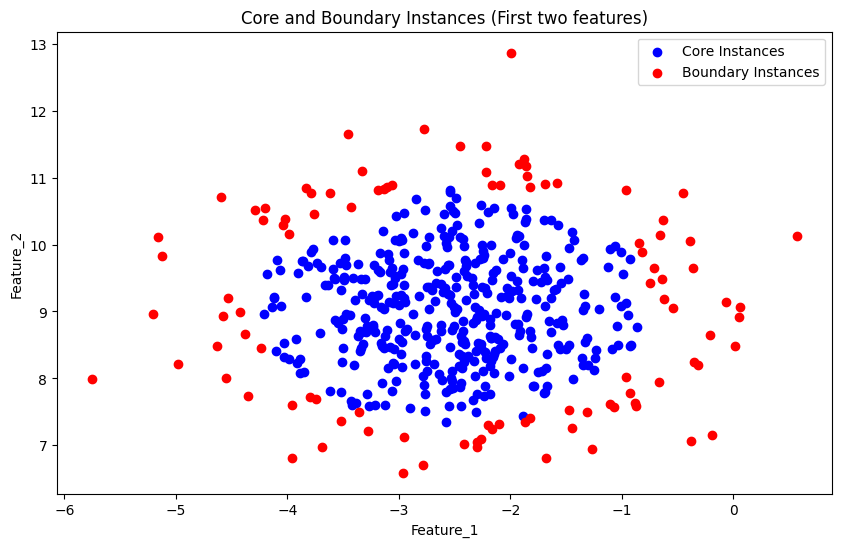

In [39]:
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import numpy as np

# DATA GENERATION
n_samples = 500   # Specifies data samples for entire dataset (not single class)
n_features = 2    # Number of features - Any value greater than 2
n_classes = 1     # Number of classes
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=1.0, random_state=42)

# DATA FRAME
feature_columns = [f'Feature_{i+1}' for i in range(n_features)]  # List of features ['Feature_1', 'Feature_2']
data = pd.DataFrame(X, columns=feature_columns)                  # Dataframe created
data['Class'] = y

# CLASS SELECTION
class_1_data = data[data['Class'] == 0]                          # Select class to analyze
class_1_data_features = class_1_data.drop(columns=['Class'])     # Class 0 filtered

# PAIRWISE DISTANCES
distances = pdist(class_1_data_features, metric='euclidean')     # Calculate euclidian distance between each pair of points
                                                                 # ... (inlcuding itself) and stored a 1 dimensional array
distance_matrix = squareform(distances)                          # Distances stored as 2 dimensional matrix

# AVERAGE DISTANCES
np.fill_diagonal(distance_matrix, np.nan)                              # Set diagonal (0) to NaN
average_distances = np.nanmean(distance_matrix, axis=1)                # Average distance for each instance, excluding NaN values
class_1_data = class_1_data.assign(Average_Distance=average_distances) # Assign the average distance to the DataFrame

# THRESHOLD TO CLASSIFY INTO CORE AND BOUNDARY
threshold = class_1_data['Average_Distance'].quantile(0.8)                      # Threshold as 80%
core_instances = class_1_data[class_1_data['Average_Distance'] <= threshold]
boundary_instances = class_1_data[class_1_data['Average_Distance'] > threshold]

# PLOT
plt.figure(figsize=(10, 6))
plt.scatter(core_instances['Feature_1'], core_instances['Feature_2'], color='blue', label='Core Instances')
plt.scatter(boundary_instances['Feature_1'], boundary_instances['Feature_2'], color='red', label='Boundary Instances')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.title('Core and Boundary Instances (First two features)')
plt.legend()
plt.show()


# Oversampling

1.   Midpoint of cluster (for cluster center) found using maximum core distance between two points and calculating new midpoint value.
2.   Average distance between all points found (gives diameter) and used to find radius (to determine where the oversampled points should be placed)
3. To oversample place points midway of 2 boundary points when their distance is less than or equal to the radius.

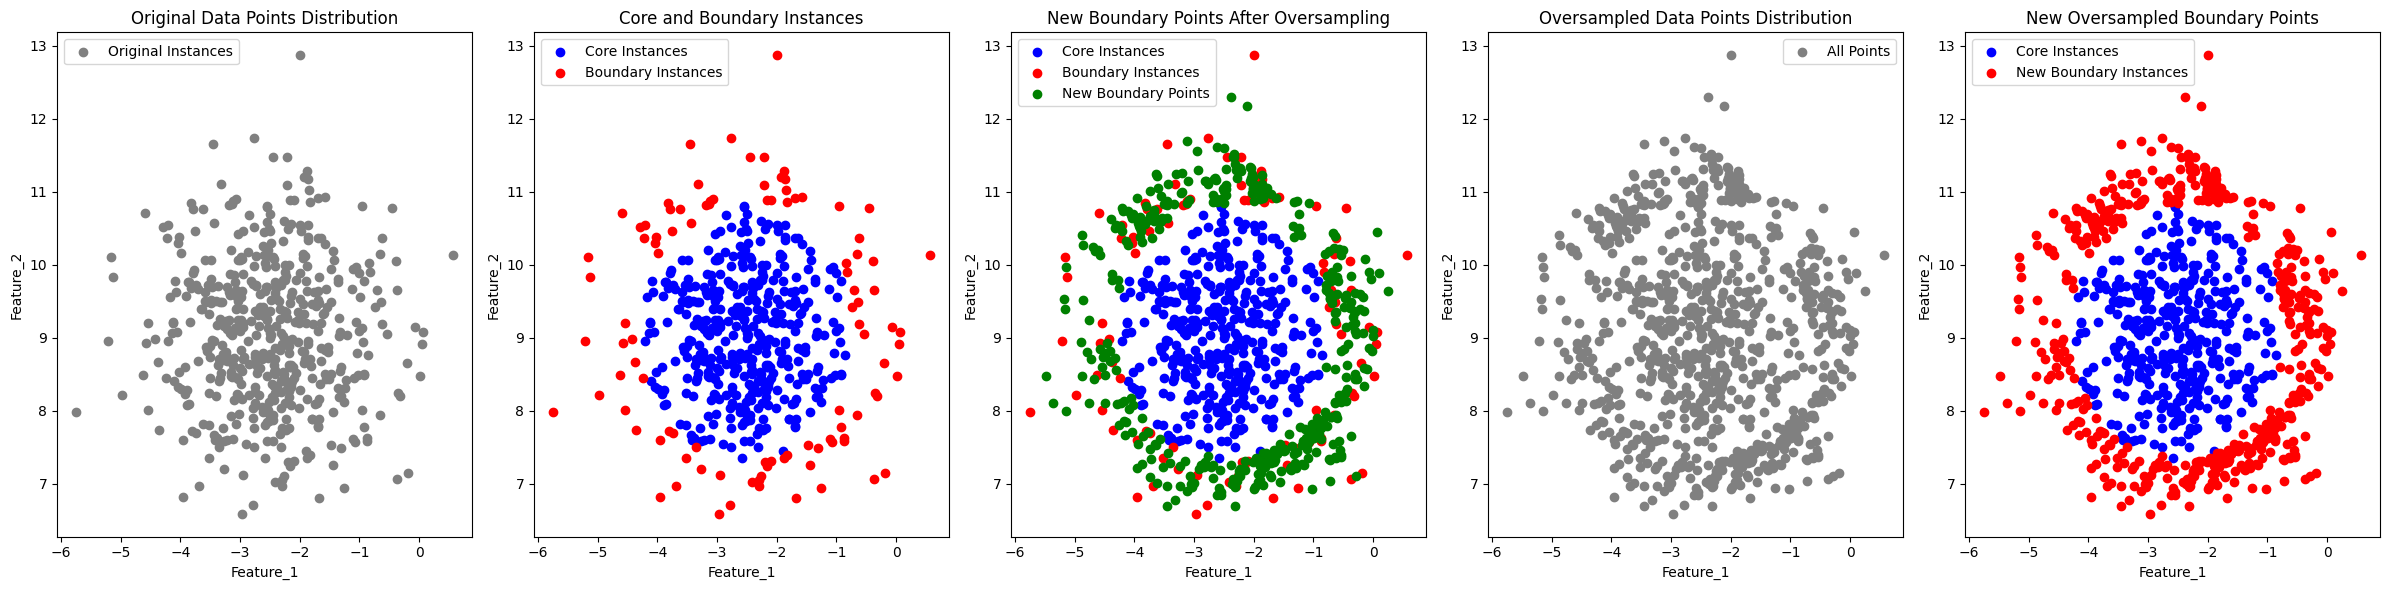

In [100]:
import random
# PAIRWISE DISTANCES FOR CORE INSTANCES
core_features = core_instances.drop(columns=['Class', 'Average_Distance']) # Contains only features
core_distances = pdist(core_features, metric='euclidean')                  # Caclulates distance between only core features
core_distance_matrix = squareform(core_distances)                          # Stored in 2D Matrix

# FINDING THE MAXIMUM DISTANCE PAIR
max_dist_index = np.unravel_index(np.nanargmax(core_distance_matrix), core_distance_matrix.shape)
point1 = core_features.iloc[max_dist_index[0]].values
point2 = core_features.iloc[max_dist_index[1]].values

# CALCULATE MIDPOINT
midpoint = (point1 + point2) / 2

# PAIRWISE DISTANCES FOR BOUNDARY INSTANCES
boundary_features = boundary_instances.drop(columns=['Class', 'Average_Distance'])
boundary_distances = pdist(boundary_features, metric='euclidean')
boundary_distance_matrix = squareform(boundary_distances)

# AVERAGE DISTANCE BETWEEN BOUNDARY POINTS
average_boundary_distance = np.nanmean(boundary_distance_matrix)

# RADIUS
radius = average_boundary_distance / 2

def create_midpoint_points(data, distance_matrix, radius, core_count, boundary_count):
    new_points = []
    threshold_distance = radius  # To place boundary points only within this distance
    num_features = data.shape[1]  # Gets the number of features
    valid_pairs = []  # Stores matrix position points within threshold distance

    max_new_points = core_count # Determine the desired number of new boundary points

    if max_new_points <= 0:
        return pd.DataFrame(columns=data.columns)  # No new points needed

    for i in range(len(data)): # Collect valid pairs
        for j in range(i + 1, len(data)):
            if distance_matrix[i, j] <= threshold_distance:
                valid_pairs.append((i, j))

    random.shuffle(valid_pairs) # So points are not clustered in one area

    for idx1, idx2 in valid_pairs: # Create new points until the limit is reached
        if len(new_points) >= max_new_points:
            break
        point1 = data.iloc[idx1].values
        point2 = data.iloc[idx2].values
        midpoint = (point1 + point2) / 2
        new_points.append(midpoint)

    return pd.DataFrame(new_points, columns=data.columns)

core_count = len(core_instances)
boundary_count = len(boundary_instances)
new_boundary_points = create_midpoint_points(boundary_features, boundary_distance_matrix, radius, core_count, boundary_count)

# PLOT
fig, axs = plt.subplots(1, 5, figsize=(24, 6))

# PLOT 1: ORIGINAL DATA POINTS BEFORE CLASSIFICATION
axs[0].scatter(class_1_data['Feature_1'], class_1_data['Feature_2'], color='grey', label='Original Instances')
axs[0].set_title('Original Data Points Distribution')
axs[0].set_xlabel('Feature_1')
axs[0].set_ylabel('Feature_2')
axs[0].legend()

# PLOT 2: CORE AND BOUNDARY INSTANCES AFTER CLASSIFICATION
axs[1].scatter(core_instances['Feature_1'], core_instances['Feature_2'], color='blue', label='Core Instances')
axs[1].scatter(boundary_instances['Feature_1'], boundary_instances['Feature_2'], color='red', label='Boundary Instances')
axs[1].set_title('Core and Boundary Instances')
axs[1].set_xlabel('Feature_1')
axs[1].set_ylabel('Feature_2')
axs[1].legend()

# PLOT 3: MIDPOINT BOUNDARY POINTS
axs[2].scatter(core_instances['Feature_1'], core_instances['Feature_2'], color='blue', label='Core Instances')
axs[2].scatter(boundary_instances['Feature_1'], boundary_instances['Feature_2'], color='red', label='Boundary Instances')
if not new_boundary_points.empty:
    axs[2].scatter(new_boundary_points['Feature_1'], new_boundary_points['Feature_2'], color='green', label='New Boundary Points')
axs[2].set_title('New Boundary Points After Oversampling')
axs[2].set_xlabel('Feature_1')
axs[2].set_ylabel('Feature_2')
axs[2].legend()

# PLOT 4: ALL POINTS AFTER OVERSAMPLING
axs[3].scatter(class_1_data['Feature_1'], class_1_data['Feature_2'], color='grey', label='All Points')
if not new_boundary_points.empty:
    axs[3].scatter(new_boundary_points['Feature_1'], new_boundary_points['Feature_2'], color='grey')
axs[3].set_title('Oversampled Data Points Distribution')
axs[3].set_xlabel('Feature_1')
axs[3].set_ylabel('Feature_2')
axs[3].legend()

# PLOT 5: NEW OVERSAMPLED BOUNDARY POINTS
axs[4].scatter(core_instances['Feature_1'], core_instances['Feature_2'], color='blue', label='Core Instances')
axs[4].scatter(boundary_instances['Feature_1'], boundary_instances['Feature_2'], color='red', label='New Boundary Instances')
if not new_boundary_points.empty:
    axs[4].scatter(new_boundary_points['Feature_1'], new_boundary_points['Feature_2'], color='red')

axs[4].set_title('New Oversampled Boundary Points')
axs[4].set_xlabel('Feature_1')
axs[4].set_ylabel('Feature_2')
axs[4].legend()

plt.tight_layout()
plt.show()


# Downsampling
1. Core points removed ramndomly to have the same number of points as in boundary.

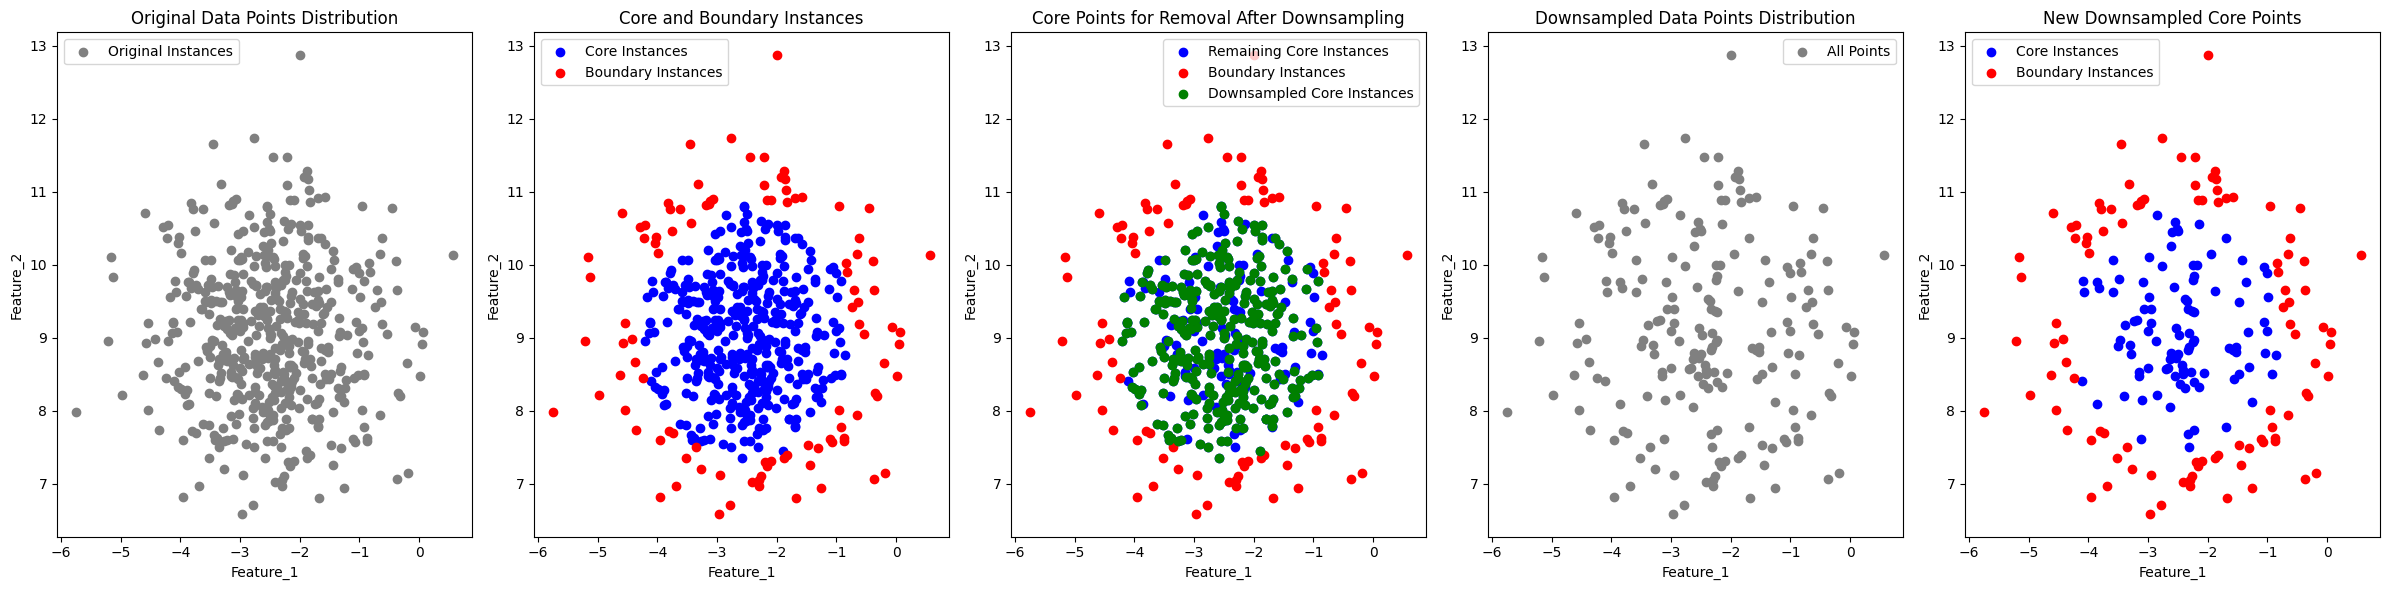

In [107]:
from sklearn.utils import resample
core_count = len(core_instances)
boundary_count = len(boundary_instances)

# DOWNSAMPLING FUNCTION
def downsample_instances(data, random_state=42):
  # return resample(data, replace=False, n_samples=int(len(data) * ratio), random_state=random_state)
  return resample(data, replace=False, n_samples= (core_count - boundary_count), random_state=random_state)

downsampled_core_data = core_instances
downsampled_core_instances = downsample_instances(downsampled_core_data)

# REMOVE DOWNSAMPLED POINTS
downsampled_final_data = downsampled_core_data.drop(downsampled_core_instances.index)

# PLOT
fig, axs = plt.subplots(1, 5, figsize=(24, 6))

# PLOT 1: ORIGINAL DATA POINTS BEFORE CLASSIFICATION
axs[0].scatter(class_1_data['Feature_1'], class_1_data['Feature_2'], color='grey', label='Original Instances')
axs[0].set_title('Original Data Points Distribution')
axs[0].set_xlabel('Feature_1')
axs[0].set_ylabel('Feature_2')
axs[0].legend()

# PLOT 2: CORE AND BOUNDARY INSTANCES AFTER CLASSIFICATION
axs[1].scatter(core_instances['Feature_1'], core_instances['Feature_2'], color='blue', label='Core Instances')
axs[1].scatter(boundary_instances['Feature_1'], boundary_instances['Feature_2'], color='red', label='Boundary Instances')
axs[1].set_title('Core and Boundary Instances')
axs[1].set_xlabel('Feature_1')
axs[1].set_ylabel('Feature_2')
axs[1].legend()

# PLOT 3: CORE POINTS TO BE REMOVED
axs[2].scatter(core_instances['Feature_1'], core_instances['Feature_2'], color='blue', label='Remaining Core Instances')
axs[2].scatter(boundary_instances['Feature_1'], boundary_instances['Feature_2'], color='red', label='Boundary Instances')
axs[2].scatter(downsampled_core_instances['Feature_1'], downsampled_core_instances['Feature_2'], color='green', label='Downsampled Core Instances')
axs[2].set_title('Core Points for Removal After Downsampling')
axs[2].set_xlabel('Feature_1')
axs[2].set_ylabel('Feature_2')
axs[2].legend()

# PLOT 4: ALL POINTS AFTER DOWNSAMPLING
axs[3].scatter(downsampled_final_data['Feature_1'], downsampled_final_data['Feature_2'], color='grey', label='All Points')
axs[3].scatter(boundary_instances['Feature_1'], boundary_instances['Feature_2'], color='grey')
axs[3].set_title('Downsampled Data Points Distribution')
axs[3].set_xlabel('Feature_1')
axs[3].set_ylabel('Feature_2')
axs[3].legend()

# PLOT 5: NEW DOWNSAMPLED CORE POINTS
axs[4].scatter(downsampled_final_data['Feature_1'], downsampled_final_data['Feature_2'], color='blue', label='Core Instances')
axs[4].scatter(boundary_instances['Feature_1'], boundary_instances['Feature_2'], color='red', label='Boundary Instances')
axs[4].set_title('New Downsampled Core Points')
axs[4].set_xlabel('Feature_1')
axs[4].set_ylabel('Feature_2')
axs[4].legend()

plt.tight_layout()
plt.show()